In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.stattools as ts
import quantstats as qs

colour_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from Trader import TradingEngine

# Download data

In [3]:
start = '2000-01-01'
end = '2025-08-01'

In [4]:
# Asset 1 data
asset_1 = yf.download('HO=F', start=start, end=end, interval='1d')
asset_1.columns = [f"{price}" for price, _ in asset_1.columns]

C:\Users\Owen\AppData\Local\Temp\ipykernel_12616\979573987.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  asset_1 = yf.download('HO=F', start=start, end=end, interval='1d')
[*********************100%***********************]  1 of 1 completed


In [5]:
# Asset 2 data
asset_2 = yf.download('RB=F', start=start, end=end, interval='1d')
asset_2.columns = [f"{price}" for price, _ in asset_2.columns]

C:\Users\Owen\AppData\Local\Temp\ipykernel_12616\2664427952.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  asset_2 = yf.download('RB=F', start=start, end=end, interval='1d')
[*********************100%***********************]  1 of 1 completed


In [6]:
df = pd.DataFrame({
    'asset_1': asset_1['Close'],
    'asset_2': asset_2['Close']
}).dropna()


In [9]:
date_split = '2020-07-31'
index_split = df.index.get_loc(date_split)

df_train will be used to perform our statistical tests on and calculate our hedge ratio. It will represent our known historical data

In [15]:
df_train = df.loc[df.index<=date_split].copy()

# Statistical tests

First we must test for cointegration of the two time series. A p-value < 0.05 below means we can reject the null hypothesis of no cointegration.

In [17]:
score, pvalue, _ = ts.coint(df_train.asset_1, df_train.asset_2)

print(f"Cointegration Test Score: {score}")
print(f"P-value: {pvalue}")


Cointegration Test Score: -6.153673915633721
P-value: 7.512150987216368e-07


Now lets use fit a regression model to determine the hedge ratio

In [20]:
X = ts.add_constant(df_train.asset_2)  # Independent variable (e.g., HO)
model = ts.OLS(df_train.asset_1, X).fit()
hedge_ratio = model.params.iloc[1]

print(f"Hedge Ratio (asset 1 vs asset 2): {hedge_ratio}")

Hedge Ratio (asset 1 vs asset 2): 1.0550348699132783


In [22]:
df['spread'] = df.asset_1 - hedge_ratio * df.asset_2
df_train['spread'] = df_train.asset_1 - hedge_ratio * df_train.asset_2

Now lets test to ensure the stationarity of our spread

In [25]:
print(ts.adfuller(df_train.spread)[1] < 0.05)

True


Pairs used so far that have passed the statistical tests:    
BZ + RB  
HO + RB  

# Some plots

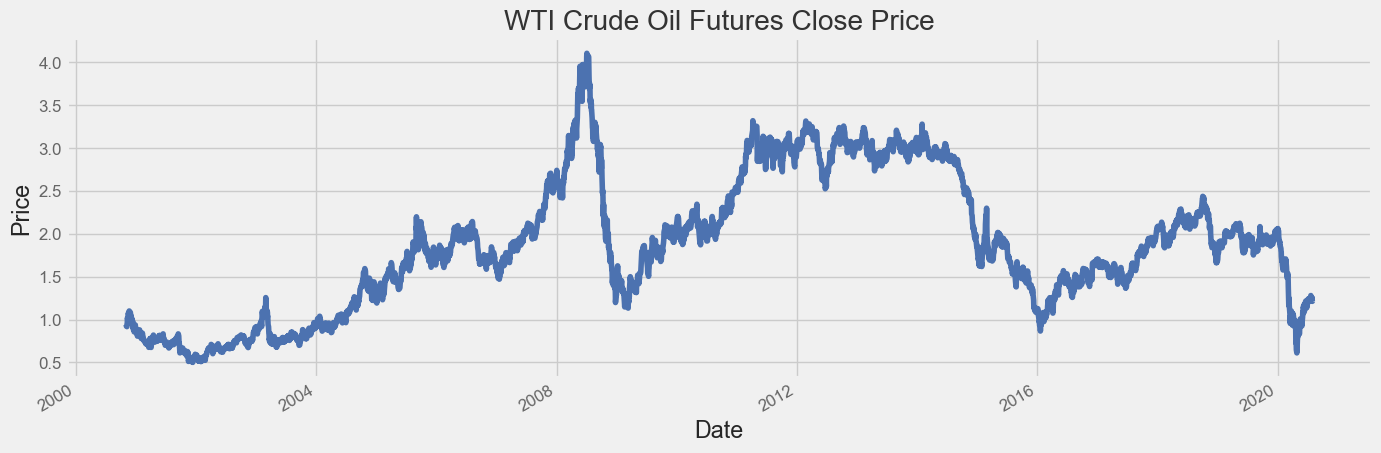

In [29]:
df_train.asset_1.plot(style='-', 
              figsize=(15,5), 
              color=colour_pal[0], 
              title='WTI Crude Oil Futures Close Price', 
              ylabel='Price')
plt.show()

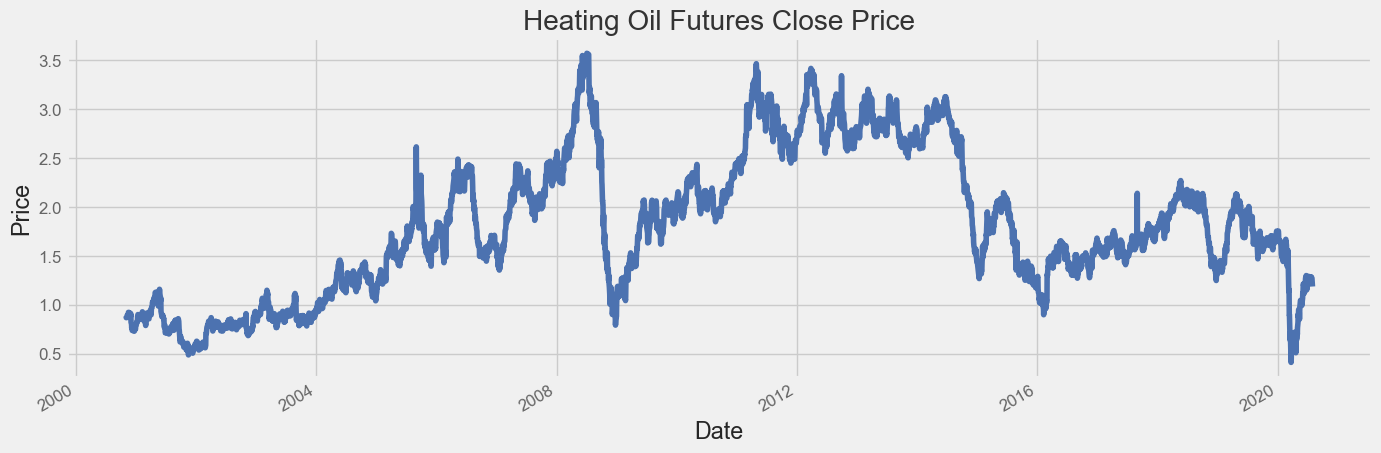

In [31]:
df_train.asset_2.plot(style='-', 
              figsize=(15,5), 
              color=colour_pal[0], 
              title='Heating Oil Futures Close Price', 
              ylabel='Price')
plt.show()

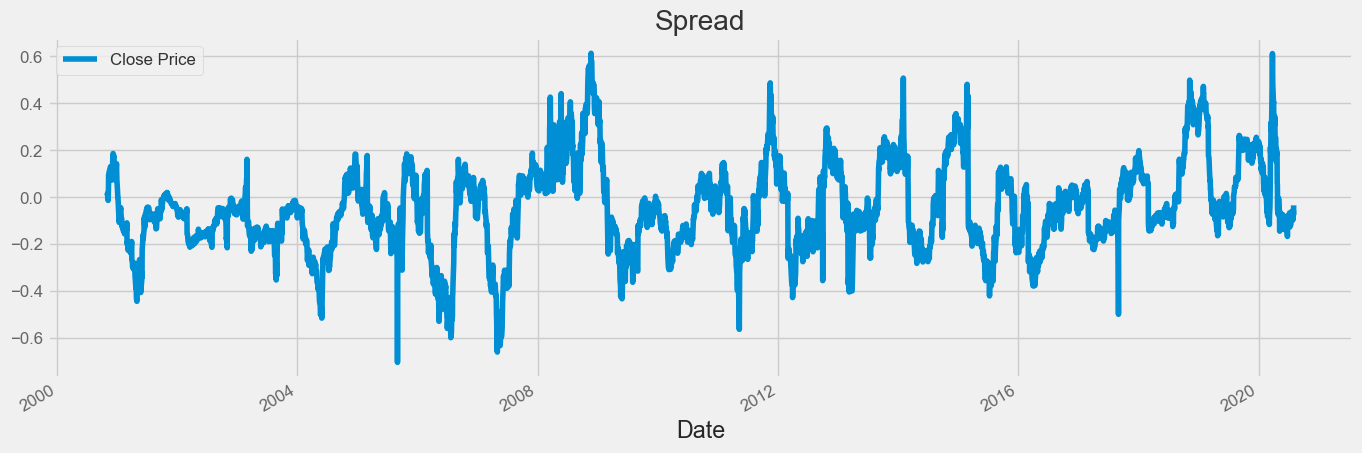

In [35]:
fig, ax = plt.subplots(figsize=(15,5))
df_train.spread.plot(ax=ax, label='Close Price', title='Spread')
ax.legend()
plt.show()

# Implement strategy on training data

In [45]:
# Construct upper and lower bounds based off the spreads trend and volatility
n_stds = 2
rolling_window = 252    #Approximately one-year of trading days
df['spread_ma'] = df.spread.rolling(window=rolling_window).mean()
df['spread_ub'] = df.spread_ma + df.spread.rolling(window=rolling_window).std() * n_stds
df['spread_lb'] = df.spread_ma - df.spread.rolling(window=rolling_window).std() * n_stds

# Construct buy and sell signals
df['buy_signal'] = (df.spread < df.spread_lb).astype(int)
df['sell_signal'] = -(df.spread > df.spread_ub).astype(int)

In [47]:
df_train = df.loc[df.index<=date_split].copy()
df_test = df.loc[df.index>=date_split].copy()

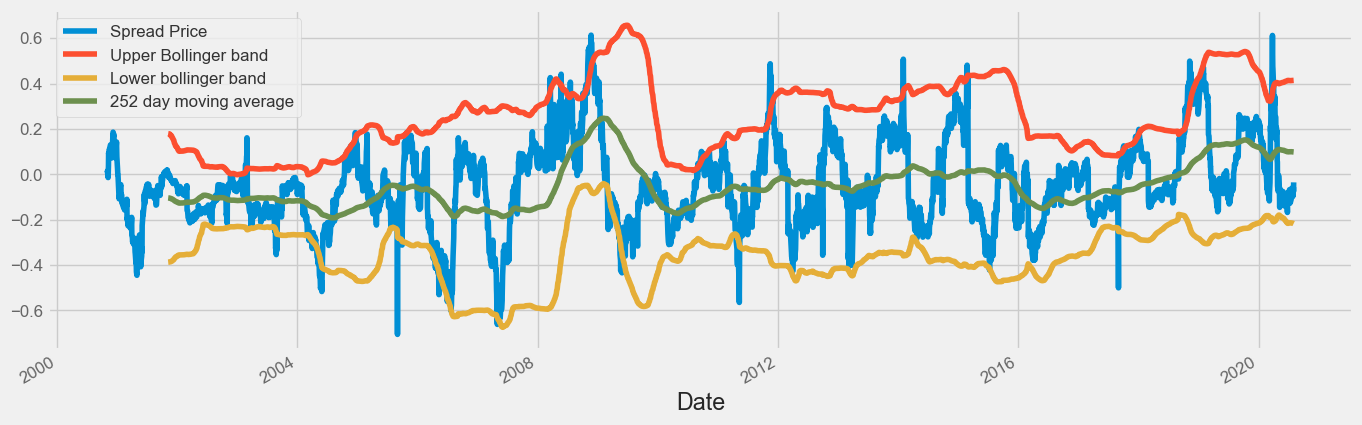

In [81]:
fig, ax = plt.subplots(figsize=(15,5))
df_train.spread.plot(ax=ax, label='Spread Price')
df_train.spread_ub.plot(ax=ax, label='Upper Bollinger band')
df_train.spread_lb.plot(ax=ax, label='Lower bollinger band')
df_train.spread_ma.plot(ax=ax, label=f'{rolling_window} day moving average')
ax.legend()
plt.show()

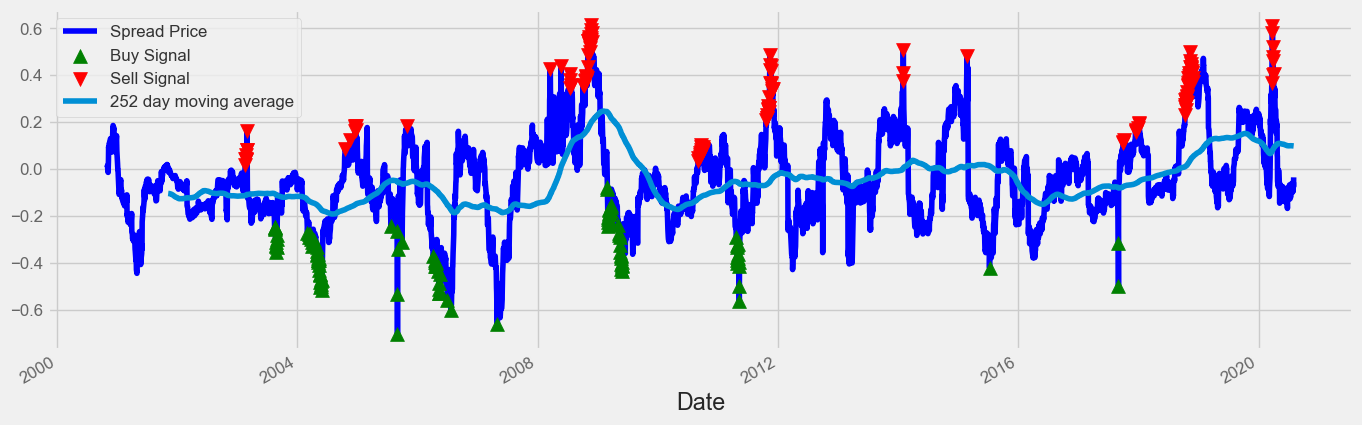

In [78]:
buy_mask = df_train.buy_signal > 0
sell_mask = df_train.sell_signal < 0

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df_train.index, df_train['spread'], label='Spread Price', color='blue')
ax.scatter(df_train.index[buy_mask], df_train['spread'][buy_mask],
            label='Buy Signal', marker='^', color='green', s=100, zorder=3)
ax.scatter(df_train.index[sell_mask], df_train['spread'][sell_mask],
            label='Sell Signal', marker='v', color='red', s=100, zorder=3)
df_train.spread_ma.plot(ax=ax, label=f'{rolling_window} day moving average')
ax.legend()
plt.show()

In [53]:
train_trader = TradingEngine(balance=1000)

In [55]:
train_returns = train_trader.run_strategy(np.array(df_train.buy_signal), np.array(df_train.sell_signal), np.array(df_train.spread), 
                    np.array(df_train.spread_ma), df_train.index, allow_negative_balance=False)

# Performance evaluation

In [58]:
print(f'Final balance: {train_trader.balance:.2f}')
print(f'Net position: {train_trader.position}')
print(f'Number of trades: {train_trader.trade_count}')

Final balance: 1070.76
Net position: 0
Number of trades: 260


                           Strategy
-------------------------  ----------
Start Period               2000-11-01
End Period                 2020-07-31
Risk-Free Rate             0.0%
Time in Market             27.0%

Cumulative Return          7.08%
CAGR﹪                     0.24%

Sharpe                     0.8
Prob. Sharpe Ratio         100.0%
Smart Sharpe               0.8
Sortino                    1.59
Smart Sortino              1.57
Sortino/√2                 1.12
Smart Sortino/√2           1.11
Omega                      1.44

Max Drawdown               -0.68%
Max DD Date                2019-01-29
Max DD Period Start        2018-12-31
Max DD Period End          2019-02-28
Longest DD Days            91
Volatility (ann.)          0.43%
Calmar                     0.35
Skew                       6.58
Kurtosis                   114.56

Expected Daily %           0.0%
Expected Monthly %         0.03%
Expected Yearly %          0.33%
Kelly Criterion            16.11%
Risk of Ruin       

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-12-31,2019-01-29,2019-02-28,60,-0.681431,-0.578761
2,2009-03-25,2009-05-27,2009-06-23,91,-0.680418,-0.641863
3,2009-07-09,2009-07-31,2009-08-31,54,-0.552881,-0.455003
4,2004-04-07,2004-05-28,2004-05-28,52,-0.474617,-0.418984
5,2018-10-17,2018-11-07,2018-11-28,43,-0.349873,-0.275950


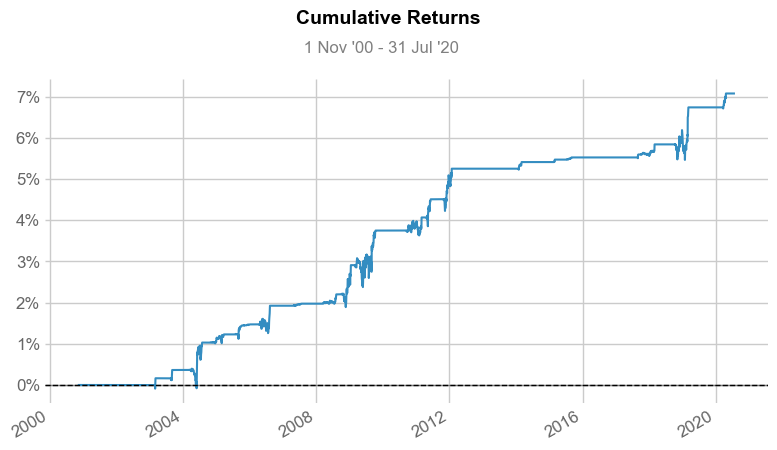

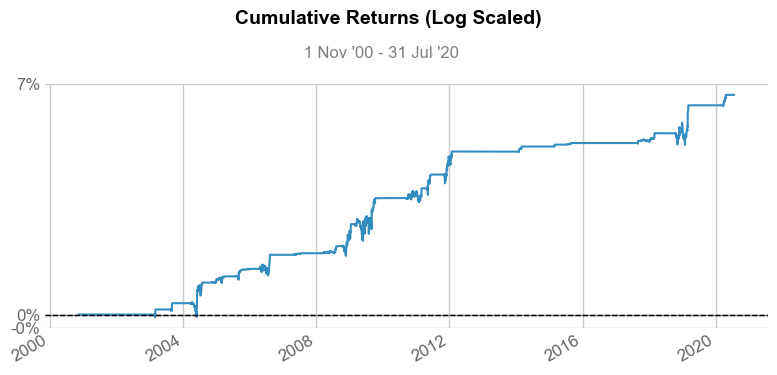

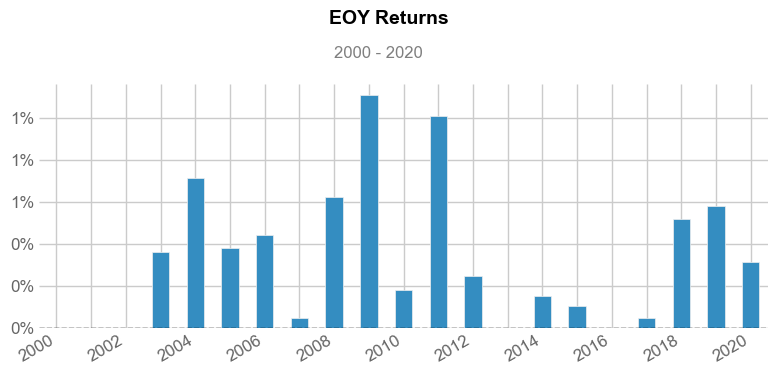

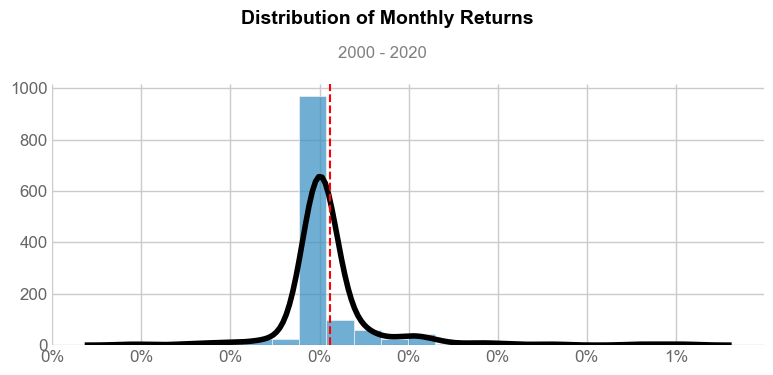

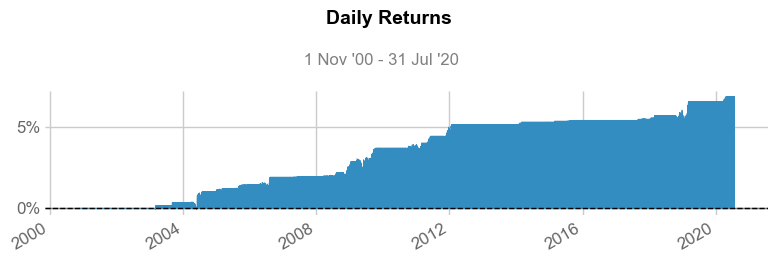

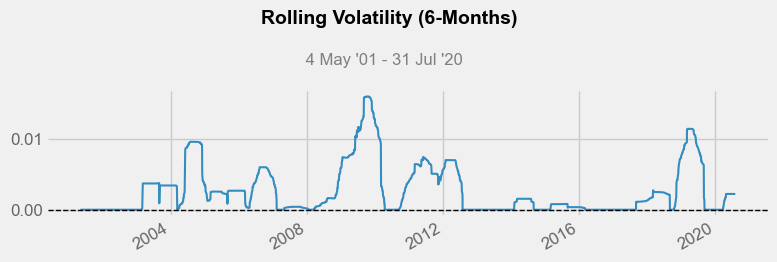

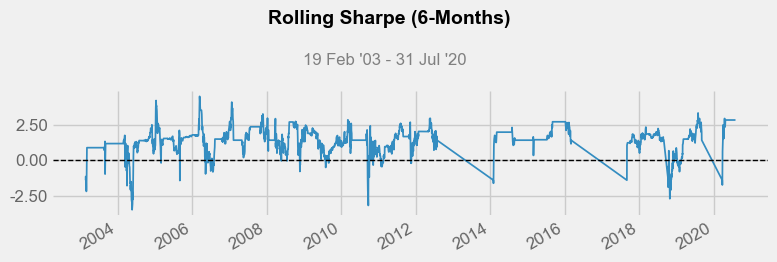

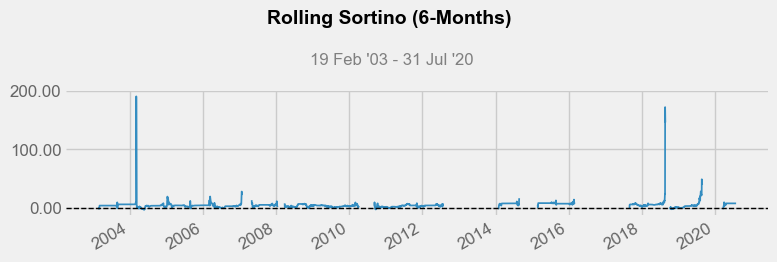

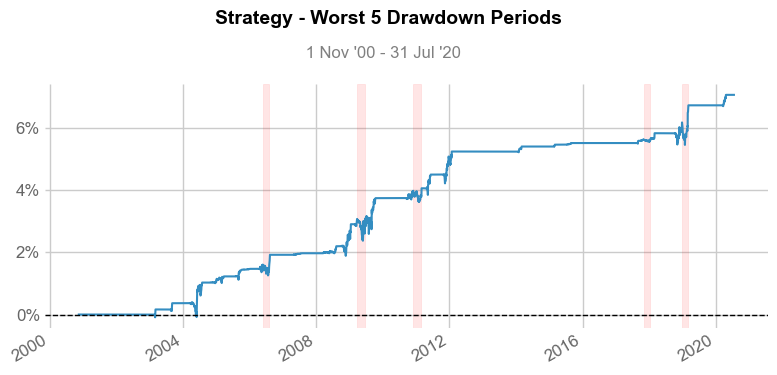

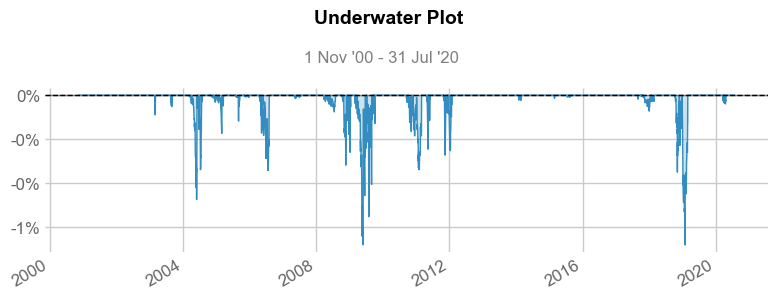

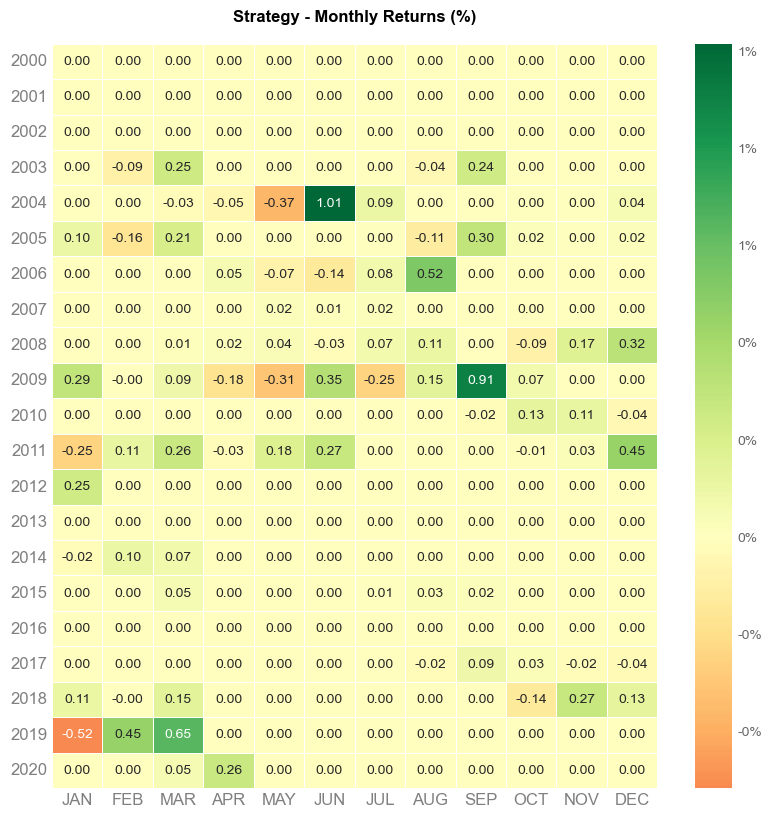

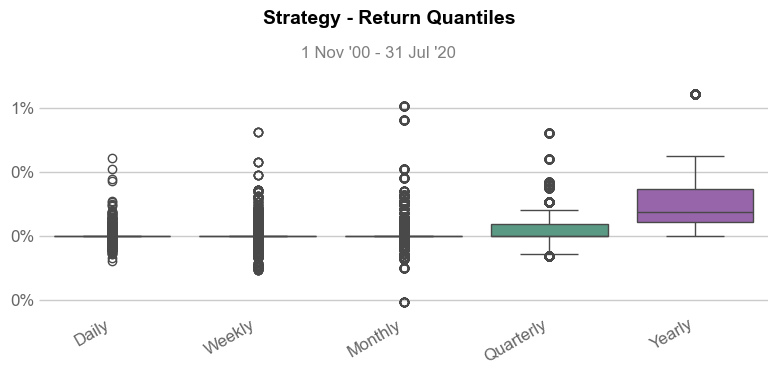

In [60]:
#qs.reports.html(returns)
qs.reports.full(train_returns)

# Backtesting

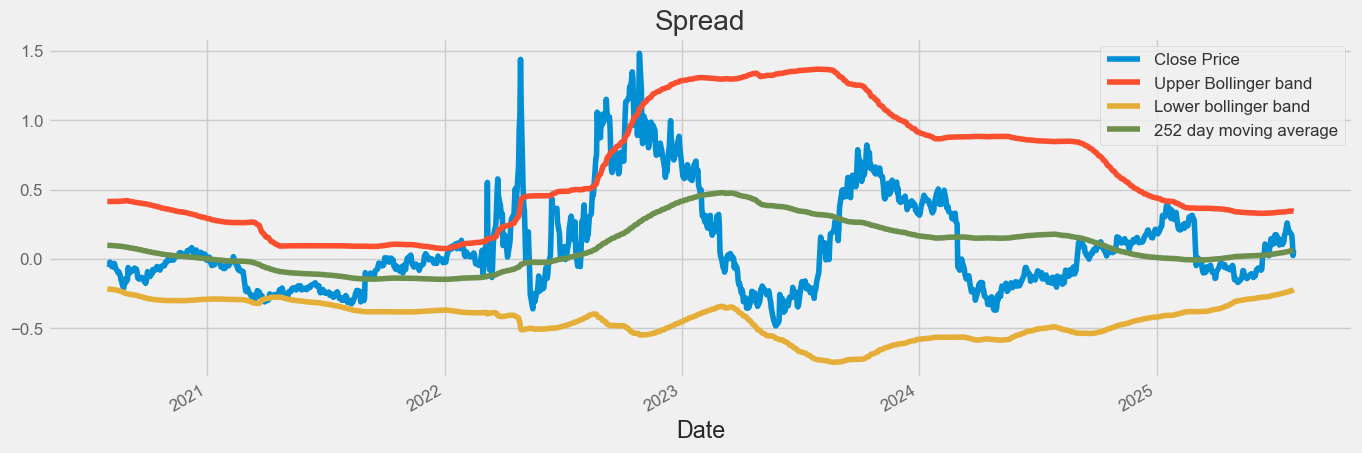

In [63]:
fig, ax = plt.subplots(figsize=(15,5))
df_test.spread.plot(ax=ax, label='Close Price', title='Spread')
df_test.spread_ub.plot(ax=ax, label='Upper Bollinger band')
df_test.spread_lb.plot(ax=ax, label='Lower bollinger band')
df_test.spread_ma.plot(ax=ax, label=f'{rolling_window} day moving average')
ax.legend()
plt.show()

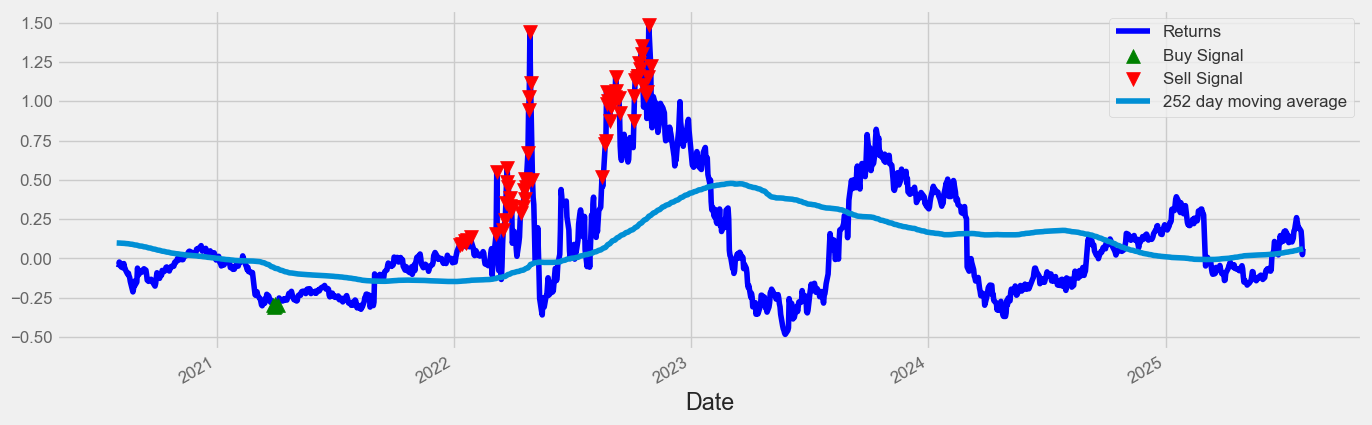

In [65]:
buy_mask = df_test.buy_signal > 0
sell_mask = df_test.sell_signal < 0

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df_test.index, df_test['spread'], label='Returns', color='blue')
ax.scatter(df_test.index[buy_mask], df_test['spread'][buy_mask],
            label='Buy Signal', marker='^', color='green', s=100, zorder=3)
ax.scatter(df_test.index[sell_mask], df_test['spread'][sell_mask],
            label='Sell Signal', marker='v', color='red', s=100, zorder=3)
df_test.spread_ma.plot(ax=ax, label=f'{rolling_window} day moving average')
ax.legend()
plt.show()

In [67]:
test_trader = TradingEngine(balance=1000)

In [69]:
test_returns = test_trader.run_strategy(np.array(df_test.buy_signal), np.array(df_test.sell_signal), np.array(df_test.spread), 
                    np.array(df_test.spread_ma), df_test.index, allow_negative_balance=False)

In [71]:
print(f'Final balance: {test_trader.balance:.2f}')
print(f'Net position: {test_trader.position}')
print(f'Number of trades: {test_trader.trade_count}')

Final balance: 1039.80
Net position: 0
Number of trades: 68


                           Strategy
-------------------------  ----------
Start Period               2020-07-31
End Period                 2025-07-31
Risk-Free Rate             0.0%
Time in Market             25.0%

Cumulative Return          3.98%
CAGR﹪                     0.54%

Sharpe                     0.5
Prob. Sharpe Ratio         87.8%
Smart Sharpe               0.43
Sortino                    0.82
Smart Sortino              0.69
Sortino/√2                 0.58
Smart Sortino/√2           0.49
Omega                      1.3

Max Drawdown               -2.2%
Max DD Date                2022-04-28
Max DD Period Start        2022-04-11
Max DD Period End          2022-05-03
Longest DD Days            76
Volatility (ann.)          1.57%
Calmar                     0.25
Skew                       2.47
Kurtosis                   58.87

Expected Daily %           0.0%
Expected Monthly %         0.06%
Expected Yearly %          0.65%
Kelly Criterion            12.42%
Risk of Ruin          

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-04-11,2022-04-28,2022-05-03,23,-2.202193,-1.565245
2,2022-09-27,2022-10-28,2022-11-01,36,-1.914633,-1.403194
3,2022-12-08,2022-12-15,2023-01-03,27,-1.305432,-1.022617
4,2022-11-03,2022-11-04,2022-11-10,8,-0.637028,-0.616573
5,2022-11-14,2022-11-15,2022-11-21,8,-0.594305,-0.532655


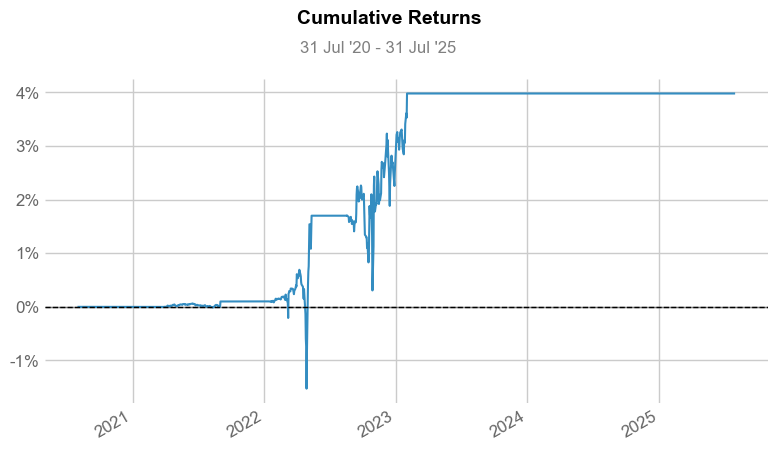

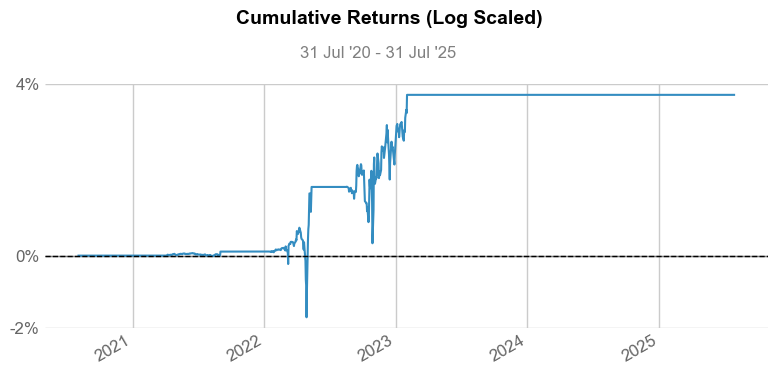

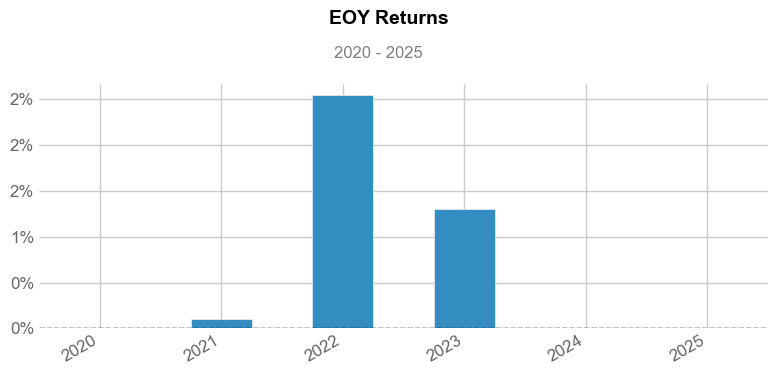

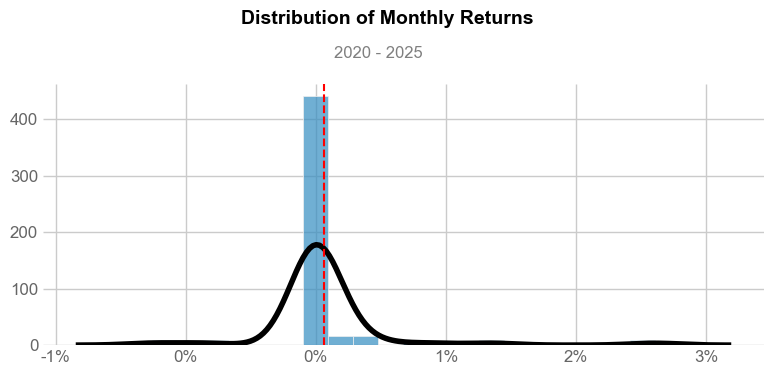

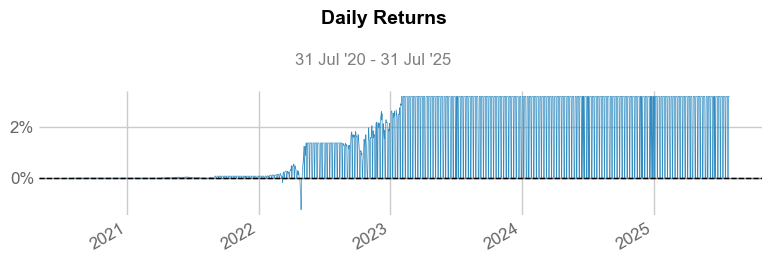

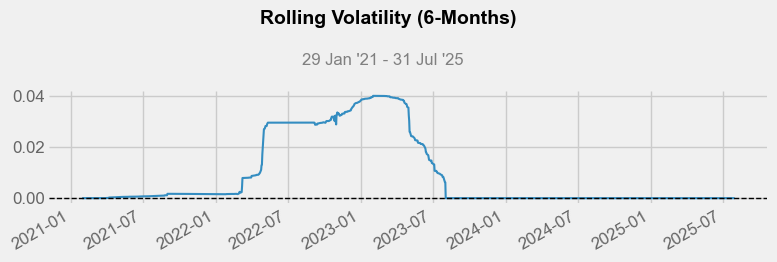

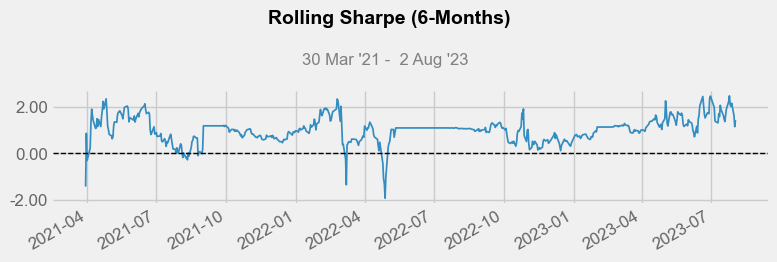

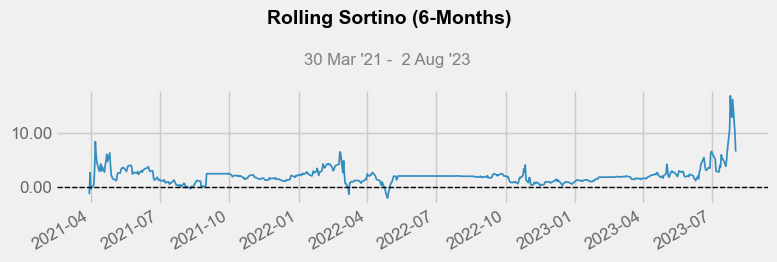

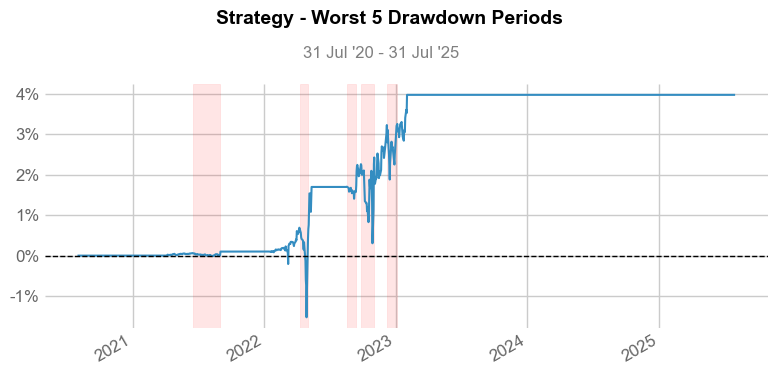

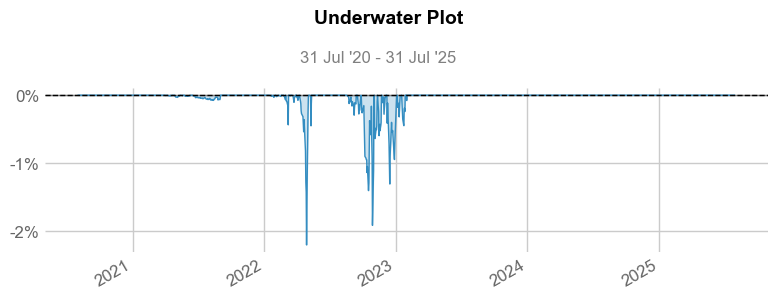

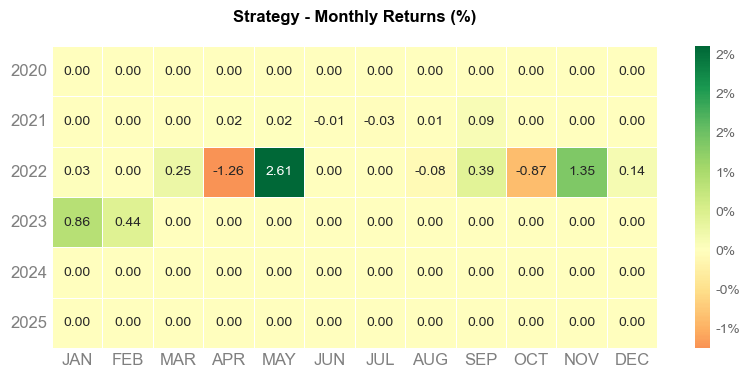

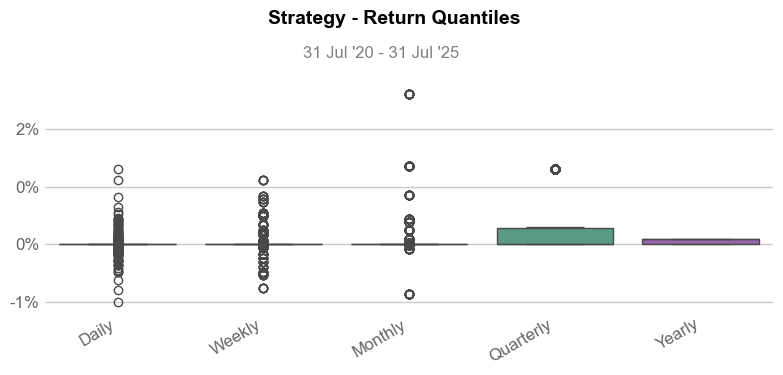

In [73]:
qs.reports.full(test_returns)